In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [178]:
path = './data/AmesHousing.txt'

data = pd.read_table(path, index_col=0)

In [179]:
data.head(5)

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [180]:
data.shape[0]

2930

According to kaggle description, this dataset doesn't contain any errors in data entries or physically impossible values.

In [181]:
# drop column PID, it's useless
data.drop('PID', axis=1, inplace=True)

Let's look for outliers in histograms

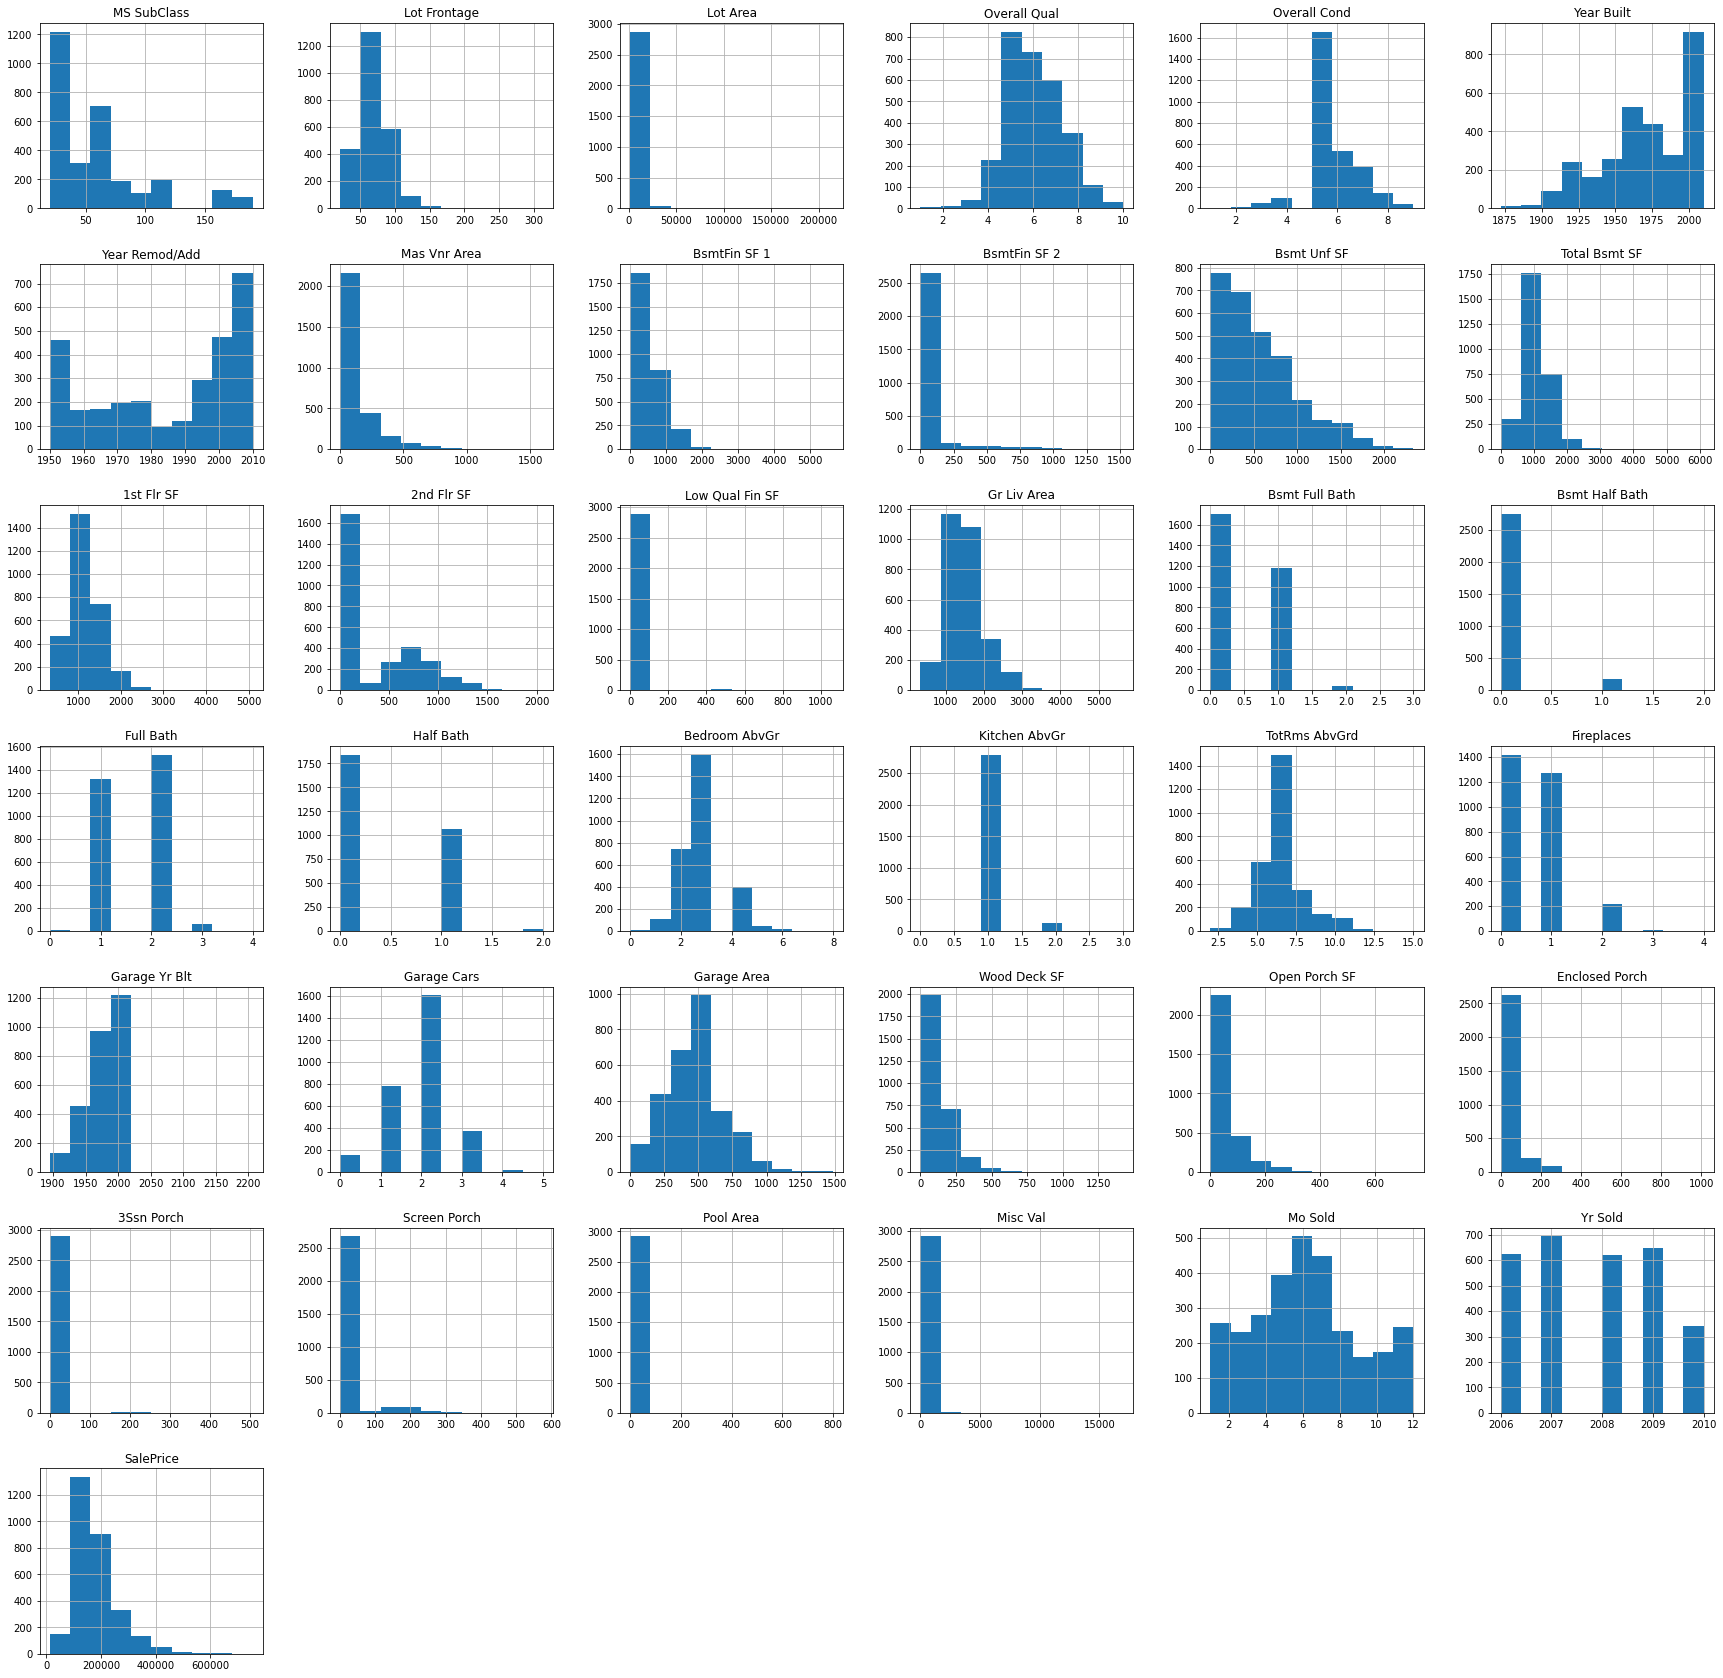

In [182]:
data.hist(figsize=(30, 30));

We can see that the tail of distribution of target varible is very heavy so it should be good to cut it using rule of 3 sigma. Also it seems reasonable to filter 'Garage Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val'.

In [183]:
cols_to_filter = ['SalePrice', 'Garage Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val']
for col in cols_to_filter:
    threshold = data[col].quantile(0.997)
    data = data.loc[data[col] < threshold, :]

Let's check if there are any redundant features

In [186]:
data.count().sort_values()

Pool QC           10
Misc Feature      95
Alley            195
Fence            560
Fireplace Qu    1466
                ... 
Exterior 2nd    2874
Exterior 1st    2874
Roof Matl       2874
BsmtFin SF 1    2874
SalePrice       2874
Length: 80, dtype: int64

We have 3 features which have useful values in less than 10% of all entries. Probably it's best to drop them.

In [203]:
data.drop(['Pool QC', 'Misc Feature', 'Alley'], axis=1, inplace=True)

We have 2 time features in our dataset, 'Mo Sold' and 'Yr Sold'. Let's inspect them

In [237]:
print(data['Mo Sold'].isna().sum())
print(data['Yr Sold'].isna().sum())

0
0


It seems we don't need to take any additional measures

Let's lower precision for speed purposes

In [135]:
float_cols = data.select_dtypes(include='float64').columns
int_cols = data.select_dtypes(include='int64').columns

data.loc[:, float_cols] = data.loc[:, float_cols].astype('float32')
data.loc[:, int_cols] = data.loc[:, int_cols].astype('int32')

Let's split our columns based on their type.

In [136]:
col_by_type = defaultdict(list)
for index, value in data.dtypes.items():
    col_by_type[str(value)].append(index)

col_by_type.keys()

dict_keys(['int32', 'object', 'float32'])

For all columns with 'object' dtype we'll fill their NaNs with 'missing' value.

In [137]:
data.loc[:, col_by_type['object']] = data.loc[:, col_by_type['object']].fillna('missing')
data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.0,31770,Pave,missing,IR1,Lvl,AllPub,Corner,...,0,missing,missing,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.0,11622,Pave,missing,Reg,Lvl,AllPub,Inside,...,0,missing,MnPrv,missing,0,6,2010,WD,Normal,105000
3,20,RL,81.0,14267,Pave,missing,IR1,Lvl,AllPub,Corner,...,0,missing,missing,Gar2,12500,6,2010,WD,Normal,172000
4,20,RL,93.0,11160,Pave,missing,Reg,Lvl,AllPub,Corner,...,0,missing,missing,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.0,13830,Pave,missing,IR1,Lvl,AllPub,Inside,...,0,missing,MnPrv,missing,0,3,2010,WD,Normal,189900


For columns with 'float32' and 'int32' we'll first inspect unique values, taking into account their total count

In [138]:
float_cols = col_by_type['float32']
val_counts_float_cols = data[float_cols].nunique()
val_counts_float_cols

Lot Frontage       128
Mas Vnr Area       445
BsmtFin SF 1       995
BsmtFin SF 2       274
Bsmt Unf SF       1137
Total Bsmt SF     1058
Bsmt Full Bath       4
Bsmt Half Bath       3
Garage Yr Blt      103
Garage Cars          6
Garage Area        603
dtype: int64

In [139]:
few_unique_vals = val_counts_int_cols[val_counts_int_cols<=10].index
many_unique_vals = val_counts_int_cols[val_counts_int_cols>10].index

for col in few_unique_vals:
    print(col + ': ', data[col].unique())

Bsmt Full Bath:  [ 1.  0.  2.  3. nan]
Bsmt Half Bath:  [ 0.  1. nan  2.]
Garage Cars:  [ 2.  1.  3.  0.  4.  5. nan]


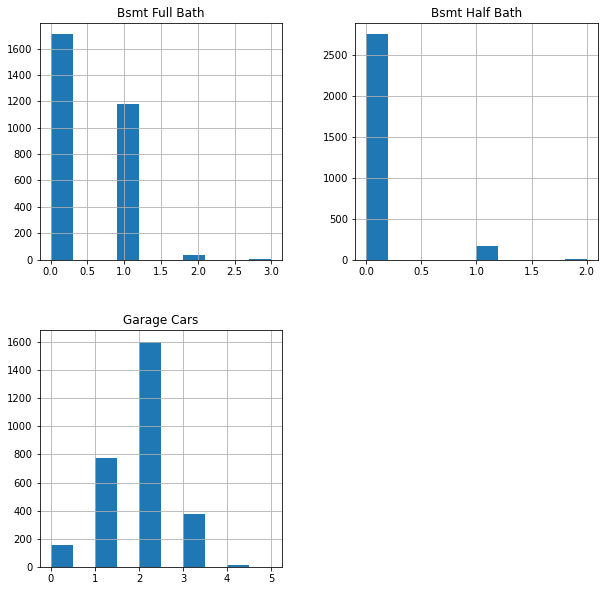

In [140]:
data[col_subset].hist(figsize=(10, 10));

As we can see, these features are in fact integer features with few unique values, so probably it would be best to fill their values with median to preserve data structure

In [141]:
data[few_unique_vals] = data[few_unique_vals].fillna(data.median()).astype('int32')

In [142]:
for col in few_unique_vals:
    col_by_type['float32'].remove(col)
    col_by_type['int32'].append(col)

For other 'float32' features we'll use mean values to fill NaNs

In [143]:
data[many_unique_vals] = data[many_unique_vals].fillna(data.mean())

For 'int32' we'll also fill NaNs with medians for features with low count of unique values\
Others we'll fill with means

In [144]:
int_cols = col_by_type['int32'][:-3]
val_counts_int_cols = data[int_cols].nunique()
val_counts_int_cols

MS SubClass          16
Lot Area           1960
Overall Qual         10
Overall Cond          9
Year Built          118
Year Remod/Add       61
1st Flr SF         1083
2nd Flr SF          635
Low Qual Fin SF      36
Gr Liv Area        1292
Full Bath             5
Half Bath             3
Bedroom AbvGr         8
Kitchen AbvGr         4
TotRms AbvGrd        14
Fireplaces            5
Wood Deck SF        380
Open Porch SF       252
Enclosed Porch      183
3Ssn Porch           31
Screen Porch        121
Pool Area            14
Misc Val             38
Mo Sold              12
Yr Sold               5
SalePrice          1032
dtype: int64

In [145]:
few_unique_vals = val_counts_int_cols[val_counts_int_cols<=10].index
many_unique_vals = val_counts_int_cols[val_counts_int_cols>10].index

data[few_unique_vals] = data[few_unique_vals].fillna(data.median())
data[many_unique_vals] = data[many_unique_vals].fillna(data.mean())

In [146]:
data

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.000000,31770,Pave,missing,IR1,Lvl,AllPub,Corner,...,0,missing,missing,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.000000,11622,Pave,missing,Reg,Lvl,AllPub,Inside,...,0,missing,MnPrv,missing,0,6,2010,WD,Normal,105000
3,20,RL,81.000000,14267,Pave,missing,IR1,Lvl,AllPub,Corner,...,0,missing,missing,Gar2,12500,6,2010,WD,Normal,172000
4,20,RL,93.000000,11160,Pave,missing,Reg,Lvl,AllPub,Corner,...,0,missing,missing,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.000000,13830,Pave,missing,IR1,Lvl,AllPub,Inside,...,0,missing,MnPrv,missing,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,80,RL,37.000000,7937,Pave,missing,IR1,Lvl,AllPub,CulDSac,...,0,missing,GdPrv,missing,0,3,2006,WD,Normal,142500
2927,20,RL,69.224586,8885,Pave,missing,IR1,Low,AllPub,Inside,...,0,missing,MnPrv,missing,0,6,2006,WD,Normal,131000
2928,85,RL,62.000000,10441,Pave,missing,Reg,Lvl,AllPub,Inside,...,0,missing,MnPrv,Shed,700,7,2006,WD,Normal,132000


In [220]:
def data_cleaning(df, drop_pid=True, lower_precision=True):
    if drop_pid:
        df.drop('PID', axis=1, inplace=True)
        
    cols_to_filter = ['SalePrice', 'Garage Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val']
    for col in cols_to_filter:
        threshold = df[col].quantile(0.997)
        df = df.loc[df[col] < threshold, :]
    
    df.drop(['Pool QC', 'Misc Feature', 'Alley'], axis=1, inplace=True)
    
    float_type = 'float64'
    int_type = 'int64'
    if lower_precision:
        float_cols = df.select_dtypes(include=float_type).columns
        int_cols = df.select_dtypes(include=int_type).columns
        
        new_float_type, new_int_type = 'float32', 'int32'
        df.loc[:, float_cols] = df.loc[:, float_cols].astype(new_float_type)
        df.loc[:, int_cols] = df.loc[:, int_cols].astype(new_int_type)
        float_type, int_type = new_float_type, new_int_type
    
    col_by_type = defaultdict(list)
    for index, value in df.dtypes.items():
        col_by_type[str(value)].append(index)
        
    df.loc[:, col_by_type['object']] = df.loc[:, col_by_type['object']].fillna('missing')
    
    float_cols = col_by_type[float_type]
    val_counts_float_cols = data[float_cols].nunique()
    
    few_unique_vals = val_counts_float_cols[val_counts_float_cols<=10].index
    many_unique_vals = val_counts_float_cols[val_counts_float_cols>10].index
    
    df[few_unique_vals] = df[few_unique_vals].fillna(df.median()).astype(int_type)
    df[many_unique_vals] = df[many_unique_vals].fillna(df.mean())
    
    for col in few_unique_vals:
        col_by_type[float_type].remove(col)
        col_by_type[int_type].append(col)
        
    int_cols = col_by_type[int_type][:-3]
    val_counts_int_cols = df[int_cols].nunique()
    
    few_unique_vals = val_counts_int_cols[val_counts_int_cols<=10].index
    many_unique_vals = val_counts_int_cols[val_counts_int_cols>10].index

    df[few_unique_vals] = df[few_unique_vals].fillna(df.median())
    df[many_unique_vals] = df[many_unique_vals].fillna(df.mean())
    
    return df

In [221]:
test_data = pd.read_table(path, index_col=0)

In [222]:
data_cleaning(test_data)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.00000,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.00000,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,0,MnPrv,0,6,2010,WD,Normal,105000
4,20,RL,93.00000,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.00000,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,189900
6,60,RL,78.00000,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,missing,0,6,2010,WD,Normal,195500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,80,RL,37.00000,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,GdPrv,0,3,2006,WD,Normal,142500
2927,20,RL,68.70414,8885,Pave,IR1,Low,AllPub,Inside,Mod,...,0,0,0,MnPrv,0,6,2006,WD,Normal,131000
2928,85,RL,62.00000,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,700,7,2006,WD,Normal,132000
